In [1]:
import rlssm
import pandas as pd
import os

#### Import the grouped data

In [2]:
data = pd.read_csv('../../data/data_experiment.csv', index_col=0)

data = data[data.participant < 6].reset_index(drop=True)

data['feedback_type'] = 0

data

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy,feedback_type
0,1,1,1,43,39,2,1,1,1.244082,0,0
1,1,1,2,60,50,4,3,1,1.101821,1,0
2,1,1,3,44,36,4,2,2,1.029923,0,0
3,1,1,4,55,55,4,3,2,1.368007,0,0
4,1,1,5,52,49,4,3,3,1.039329,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1193,5,3,76,30,41,2,1,38,1.519859,1,0
1194,5,3,77,50,41,2,1,39,1.080896,1,0
1195,5,3,78,56,49,4,3,38,1.092218,1,0
1196,5,3,79,58,35,3,1,39,0.809706,1,0


#### Initialise the model

In [3]:
model = rlssm.RLRDModel_2A(2,
                           separate_learning_rates=True,
                           nonlinear_mapping=True)

INFO:cmdstanpy:compiling stan file /Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RLRDM_2A/hierRLRDM_2A_2lr_nonlin.stan to exe file /Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RLRDM_2A/hierRLRDM_2A_2lr_nonlin
INFO:cmdstanpy:compiled model executable: /Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RLRDM_2A/hierRLRDM_2A_2lr_nonlin
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RLRDM_2A/hierRLRDM_2A_2lr_nonlin.hpp /Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RLRDM_2A/hierRLRDM_2A_2lr_nonlin.stan
Warning in '/Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RLRDM_2A/hierRLRDM_2A_2lr_nonlin.stan', line 52, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to


In [4]:
model.family, model.model_label, model.hierarchical_levels

('RLRDM_2A', 'hierRLRDM_2A_2lr_nonlin', 2)

### Fit

In [5]:
# sampling parameters
n_iter = 500
n_chains = 2
n_thin = 5

# learning parameters
K = 4 # n options
initial_value_learning = 17.5 # intitial value (Q0)

# bayesian model
alpha_priors = {'mu_mu':0, 'sd_mu':1, 'mu_sd':0, 'sd_sd':.1}
threshold_priors = {'mu_mu':1, 'sd_mu':3, 'mu_sd':0, 'sd_sd':3}
ndt_priors = {'mu_mu':1, 'sd_mu':1, 'mu_sd':0, 'sd_sd':1}
slop_priors = {'mu_mu':-1, 'sd_mu':0.5, 'mu_sd':0, 'sd_sd':1}
drift_asymtot_priors = {'mu_mu':-1, 'sd_mu':1, 'mu_sd':0, 'sd_sd':1}
drift_scaling_priors = {'mu_mu':2, 'sd_mu':1, 'mu_sd':0, 'sd_sd':1}

In [6]:
model_fit = model.fit(data,
                      K,
                      initial_value_learning,
                      alpha_priors=alpha_priors,
                      drift_scaling_priors=drift_scaling_priors,
                      drift_asymtot_priors=drift_asymtot_priors,
                      threshold_priors=threshold_priors,
                      ndt_priors=ndt_priors,
                      slop_priors=slop_priors,
                      iter_warmup=n_iter,
                      iter_sampling=n_iter,
                      chains=n_chains,
                      include_last_values=False,
                      print_diagnostics =False)

Fitting the model using the priors:
alpha_pos_priors {'mu_mu': 0, 'sd_mu': 1, 'mu_sd': 0, 'sd_sd': 0.1}
alpha_neg_priors {'mu_mu': 0, 'sd_mu': 1, 'mu_sd': 0, 'sd_sd': 0.1}
ndt_priors {'mu_mu': 1, 'sd_mu': 1, 'mu_sd': 0, 'sd_sd': 1}
threshold_priors {'mu_mu': 1, 'sd_mu': 3, 'mu_sd': 0, 'sd_sd': 3}
slop_priors {'mu_mu': -1, 'sd_mu': 0.5, 'mu_sd': 0, 'sd_sd': 1}
drift_asym_priors {'mu_mu': -1, 'sd_mu': 1, 'mu_sd': 0, 'sd_sd': 1}
drift_scaling_priors {'mu_mu': 2, 'sd_mu': 1, 'mu_sd': 0, 'sd_sd': 1}
alpha_priors {'mu_mu': 0, 'sd_mu': 1, 'mu_sd': 0, 'sd_sd': 0.1}


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


#### Get Rhat

In [7]:
model_fit.rhat.describe()

,rhat
count,7281.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [8]:
model_fit.rhat.head(6)

,rhat,variable
name,,
lp__,1.0,lp__
mu_alpha_pos,1.0,mu_alpha_pos
mu_alpha_neg,1.0,mu_alpha_neg
mu_ndt,1.0,mu_ndt
mu_threshold,1.0,mu_threshold
mu_slop,1.0,mu_slop


#### Calculate wAIC

In [9]:
model_fit.waic

{'lppd': -721.2241476023128,
 'p_waic': 30.754927894707432,
 'waic': 1503.9581509940404,
 'waic_se': 75.85805550365079}

#### Get posteriors

In [10]:
model_fit.samples

,transf_mu_alpha_pos,transf_mu_alpha_neg,transf_mu_drift_scaling,transf_mu_threshold,transf_mu_ndt,transf_mu_slop,transf_mu_drift_asym,alpha_pos_sbj[1],alpha_pos_sbj[2],alpha_pos_sbj[3],...,slop_sbj[1],slop_sbj[2],slop_sbj[3],slop_sbj[4],slop_sbj[5],drift_asym_sbj[1],drift_asym_sbj[2],drift_asym_sbj[3],drift_asym_sbj[4],drift_asym_sbj[5]
0,0.033236,0.332227,2.57902,1.92008,0.624362,0.342056,0.693262,0.027350,0.015545,0.071867,...,0.616221,0.344126,0.317220,0.412132,0.251406,0.370450,0.777869,0.715071,0.523012,1.160890
1,0.035432,0.301435,2.65021,1.98364,0.604332,0.272664,0.758965,0.039456,0.013720,0.080678,...,0.355808,0.402849,0.224037,0.370279,0.331412,0.048418,2.113540,1.416830,0.053924,1.245010
2,0.039206,0.191464,3.37374,2.19393,0.532740,0.469149,0.231263,0.019499,0.022002,0.082910,...,0.713832,0.234727,0.224928,0.347006,0.363931,0.010108,1.237250,1.383710,0.133500,1.031490
3,0.032777,0.256528,2.94482,1.92429,0.571912,0.357950,0.380660,0.029141,0.017111,0.055472,...,0.592459,0.364248,0.260176,0.604964,0.302909,0.216097,0.813464,0.989807,0.289110,1.208530
4,0.044864,0.295287,2.97534,2.10337,0.424164,0.365626,0.760951,0.029576,0.013581,0.065315,...,0.510684,0.354502,0.151444,0.244868,0.357335,0.006560,1.515030,0.855874,0.091496,1.034230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.033063,0.359283,3.29951,2.14311,0.639078,0.293587,0.420869,0.020323,0.022318,0.092051,...,0.664233,0.229135,0.158079,0.542547,0.266855,0.004205,0.792719,0.953420,0.172911,1.232330
996,0.047641,0.846416,2.89776,1.84189,0.718281,0.243768,0.541010,0.034777,0.011726,0.069589,...,0.466425,0.489949,0.163665,0.295394,0.306099,0.097683,1.068200,1.039330,0.058000,1.313810
997,0.044748,0.680860,2.84342,1.81100,0.680466,0.359594,0.585989,0.031945,0.017636,0.059509,...,0.493444,0.388841,0.247700,0.381830,0.284981,0.253101,0.957286,0.743425,0.273415,0.854635
998,0.028474,0.142979,2.63591,1.54150,0.634277,0.378009,0.507061,0.028618,0.019740,0.078132,...,0.641181,0.317548,0.202037,0.546004,0.364027,0.095475,1.054150,1.291790,0.133671,1.500340


In [11]:
model_fit.trial_samples

{'drift_cor_t': array([[1.61002, 1.61002, 1.73193, ..., 2.90017, 3.36507, 2.8805 ],
        [2.01434, 2.01434, 2.13565, ..., 2.87115, 3.26032, 2.84543],
        [1.9611 , 1.9611 , 2.07711, ..., 2.82582, 3.38725, 2.80168],
        ...,
        [1.59787, 1.59787, 1.71015, ..., 2.68266, 3.32911, 2.65797],
        [1.72374, 1.72374, 1.85973, ..., 2.99402, 3.31467, 2.97578],
        [2.05884, 2.05884, 2.18002, ..., 2.45253, 2.9736 , 2.42141]]),
 'drift_inc_t': array([[1.61002 , 1.61002 , 1.50077 , ..., 2.01177 , 0.560313, 2.06038 ],
        [2.01434 , 2.01434 , 1.89542 , ..., 1.75715 , 0.30397 , 1.81187 ],
        [1.9611  , 1.9611  , 1.84534 , ..., 1.68787 , 0.315486, 1.73714 ],
        ...,
        [1.59787 , 1.59787 , 1.4957  , ..., 1.79813 , 0.42076 , 1.84094 ],
        [1.72374 , 1.72374 , 1.59116 , ..., 1.80018 , 0.328507, 1.85529 ],
        [2.05884 , 2.05884 , 1.94946 , ..., 1.37318 , 0.269247, 1.42572 ]]),
 'threshold_t': array([[1.94937, 1.94937, 1.94937, ..., 2.26162, 2.26162, 2.

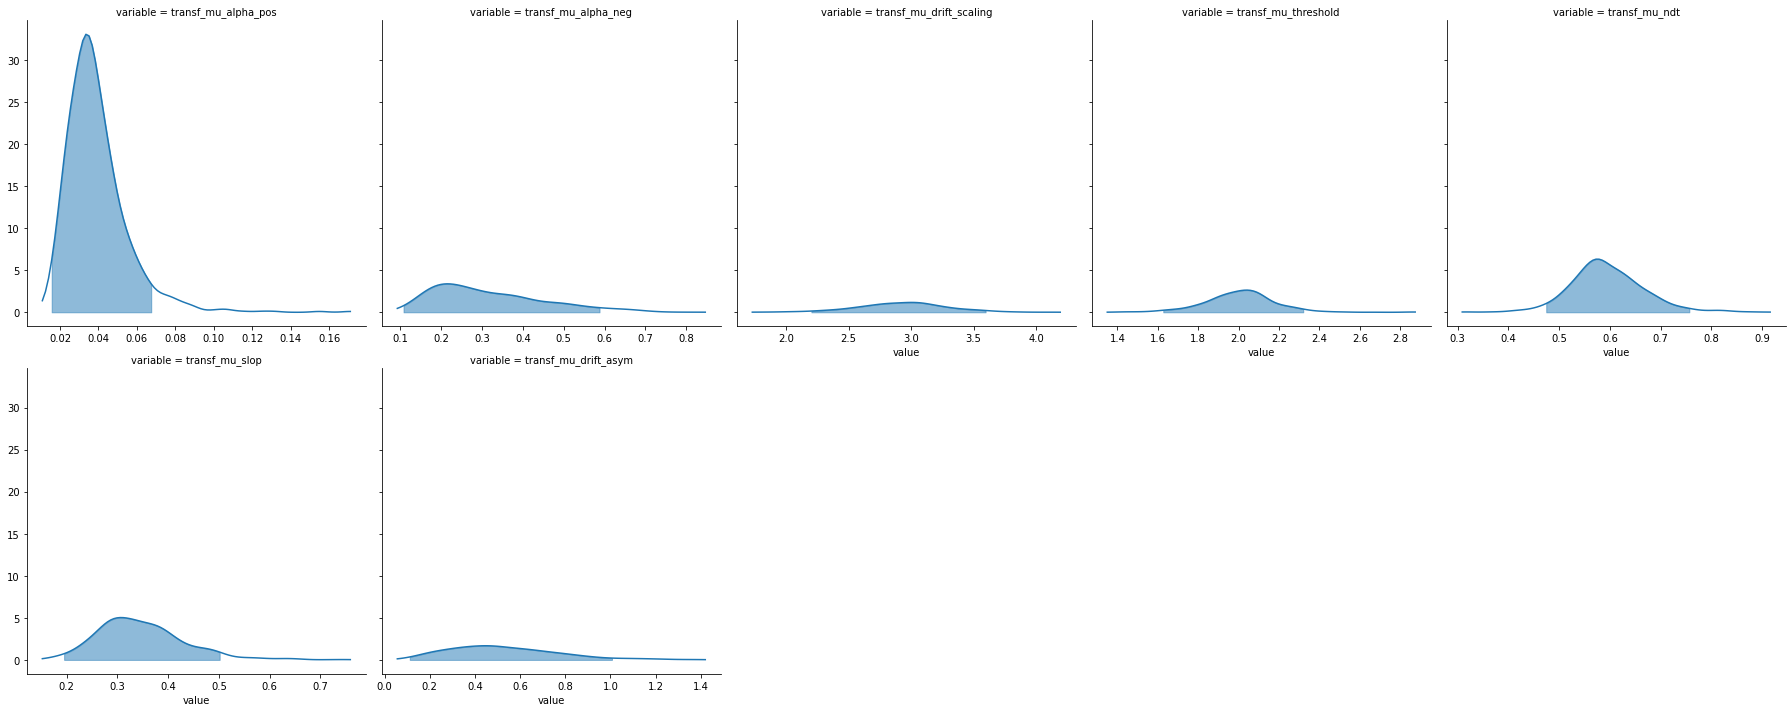

In [12]:
model_fit.plot_posteriors(height=5, show_intervals='HDI');

### Posterior predictives

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

In [15]:
data.head()

,index,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy,feedback_type,accuracy_rescale,choice_pair,block_bins
0,0,1,1,1,43,39,2,1,1,1.244082,0,0,2,AB,1
1,1,1,1,2,60,50,4,3,1,1.101821,1,0,1,CD,1
2,2,1,1,3,44,36,4,2,2,1.029923,0,0,2,BD,1
3,3,1,1,4,55,55,4,3,2,1.368007,0,0,2,CD,1
4,4,1,1,5,52,49,4,3,3,1.039329,1,0,1,CD,1


#### Ungrouped posterior predictives:

In [16]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=100)

pp.head()

variable        rt                                                    \
trial         1         2         3         4         5         6      
sample                                                                 
1         1.276296  1.119296  1.188296  1.525296  1.557296  1.819296   
2         1.380113  2.336113  1.074113  1.338113  1.947113  1.524113   
3         1.430506  1.007506  1.101506  1.373506  1.439506  1.193506   
4         0.998684  1.125684  1.222684  1.065684  1.560684  1.448684   
5         1.127731  1.310731  1.014731  2.323731  1.138731  0.929731   

variable                                          ... accuracy                 \
trial         7         8         9         10    ...     1189 1190 1191 1192   
sample                                            ...                           
1         1.395296  1.527296  1.140296  1.646296  ...      1.0  1.0  1.0  1.0   
2         1.679113  1.599113  0.917113  1.104113  ...      1.0  1.0  1.0  1.0   
3         1.203506  2.188506  1.440506  1.543506  ...      1.0  1.0  1.0  1.0   
4         1.599684  1.254684  1.181684  1.765684  ...      1.0  1.0  0.0  1.0   
5         1.216731  1.641731  1.384731  1.204731  ...      1.0  1.0  1.0  1.0   

variable                                
trial    1193 1194 1195 1196 1197 1198  
sample                                  
1         1.0  0.0  1.0  1.0  1.0  1.0  
2         1.0  1.0  1.0  1.0  1.0  1.0  
3         1.0  1.0  1.0  1.0  1.0  1.0  
4         1.0  1.0  1.0  1.0  1.0  1.0  
5         1.0  0.0  1.0  1.0  1.0  0.0  

[5 rows x 2396 columns]

#### Grouped posterior predictives:

In [17]:
pp_grouped = model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['choice_pair', 'block_bins'], 
                                                                 n_posterior_predictives=100)
pp_grouped.head()

mean_accuracy   mean_rt  skewness  \
choice_pair block_bins sample                                      
AB          1          1            0.527778  1.568638  0.537950   
                       2            0.694444  1.383281  0.541842   
                       3            0.555556  1.550503  1.530831   
                       4            0.611111  1.395165  1.521005   
                       5            0.583333  1.581495  1.312223   

                               quant_10_rt_incorrect  quant_10_rt_correct  \
choice_pair block_bins sample                                               
AB          1          1                    1.156551             1.012392   
                       2                    1.039931             1.101008   
                       3                    1.158202             1.121982   
                       4                    1.075386             1.057139   
                       5                    1.093585             1.061385   

                               quant_30_rt_incorrect  quant_30_rt_correct  \
choice_pair block_bins sample                                               
AB          1          1                    1.243461             1.191081   
                       2                    1.087931             1.292920   
                       3                    1.324623             1.401591   
                       4                    1.196576             1.186335   
                       5                    1.194455             1.190562   

                               quant_50_rt_incorrect  quant_50_rt_correct  \
choice_pair block_bins sample                                               
AB          1          1                    1.415774             1.414774   
                       2                    1.276120             1.401707   
                       3                    1.485359             1.566348   
                       4                    1.337565             1.285968   
                       5                    1.589562             1.499736   

                               quant_70_rt_incorrect  quant_70_rt_correct  \
choice_pair block_bins sample                                               
AB          1          1                    1.746461             1.919296   
                       2                    1.350931             1.455988   
                       3                    1.637206             1.763021   
                       4                    1.433233             1.507085   
                       5                    1.684116             1.669731   

                               quant_90_rt_incorrect  quant_90_rt_correct  
choice_pair block_bins sample                                              
AB          1          1                    2.229520             2.172935  
                       2                    1.561113             1.855331  
                       3                    1.858418             1.863310  
                       4                    1.705686             1.959185  
                       5                    2.186570             2.119731

#### Plot grouped posterior predictives:

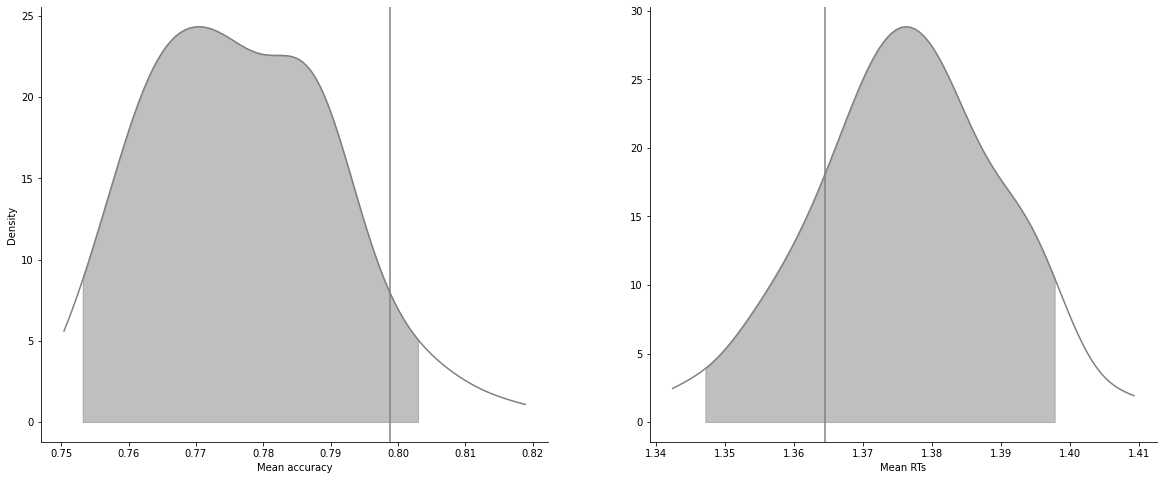

In [18]:
model_fit.plot_mean_posterior_predictives(n_posterior_predictives=100,
                                          figsize=(20,8),
                                          show_intervals='HDI');

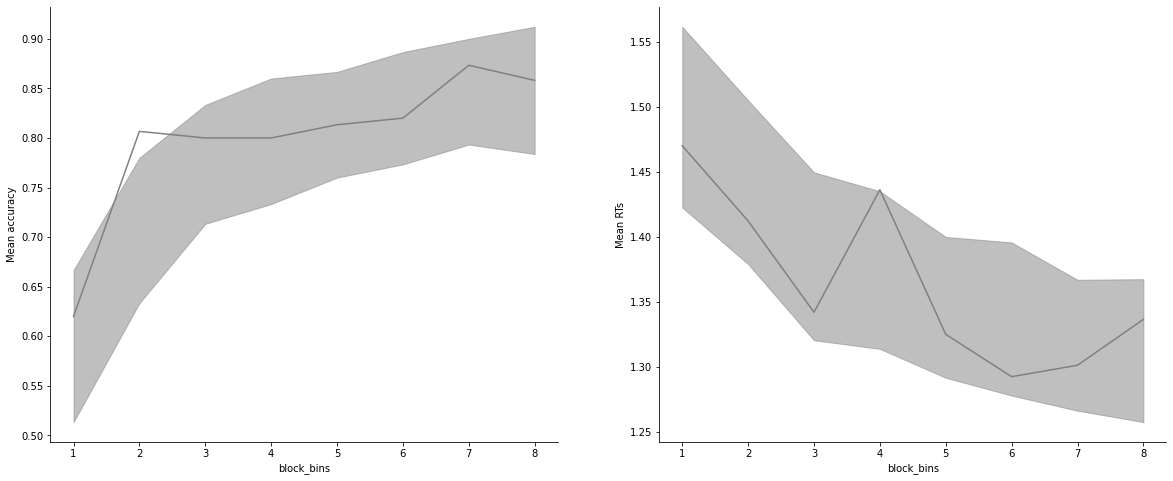

In [19]:
model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'],
                                                  n_posterior_predictives=300,
                                                  figsize=(20,8));

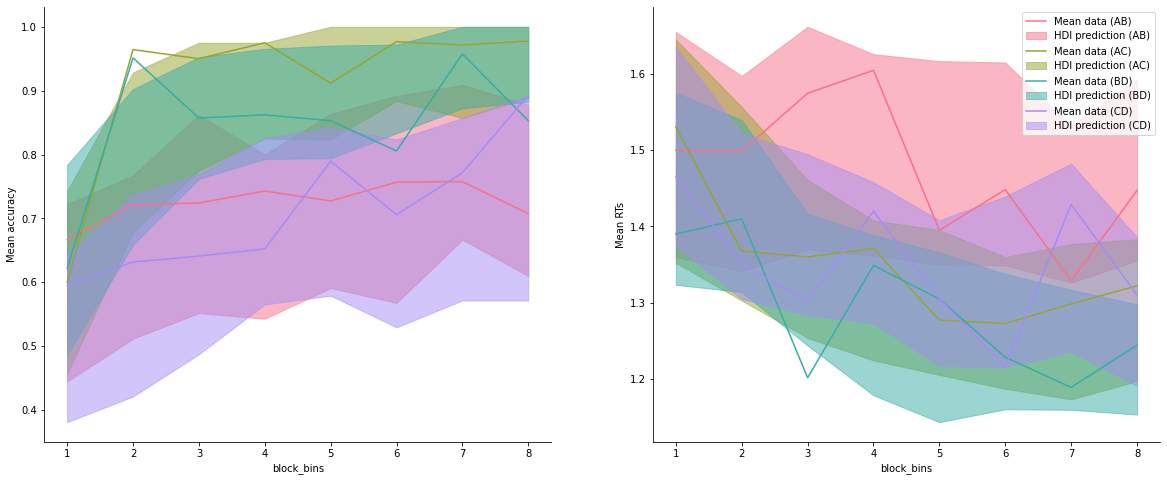

In [20]:
model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins', 'choice_pair'], 
                                                  n_posterior_predictives=100, 
                                                  figsize=(20,8));
